# Classification of Land Cover Tutorial 

Land Use and Land Cover classifications are used to identify the dominant land cover or land use type in an area. This tutorial illustrates how to use machine learning in land cover classification. Specifically, we use the Naive Bayes classifier, as implemented within `scikit-learn` library. This tutorial borrows heavily from the very helpful [tutorial](http://patrickgray.me/open-geo-tutorial/chapter_5_classification.html) developed by Chris Holden and updated by Patrick Gray. Also used: `rasterio`, `geopandas`, `numpy`, `shapely`, and `matplotlib`.

## The Challenge

Our client required a rapid approach for evaluating the benefits of conservation projects to Mule Deer. We proposed using Ecological State and Transition Models (STMs) as the basis for the evaluation. The NRCS has developed STMs for the dominant ecological sites within the region, however only a subset of the region was mapped. We use vegetation data (provided by the [Rangelands App](rangelands.app)) and other environmental variables to predict STM for the unmapped areas of the range.   

### Import Statements

In [23]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

# ipywidgets is used to create a progress bar
from ipywidgets import IntProgress
from IPython.display import display

In [24]:
%matplotlib inline

## Import Data

Naive Bayes is a supervised classification technique. We'll need both labels and predictor features to train the model. Our labels will come from the mapped STM derived from NRCS data. To begin, we'll use vegetation data as predictors, including cover estimates for trees, shrubs, perennial grasses and forbs, and bare ground.

In [25]:
# CHANGE TO VEG_COVER_PATH 
# Read in features and training data
train_path = r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\train_clip_utm.tif'
data = rasterio.open(train_path)
data.crs  # Check the projection, all features must share a projection

CRS.from_dict(init='epsg:26913')

In [26]:
labels_path = r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\labels.shp'
labels = gpd.read_file(labels_path)
labels.crs

{'init': 'epsg:26913'}

In [27]:
len(labels)

6136

We have 6,136 labeled features, represented as polygons within a geopandas dataframe, while our predictor features are represented in a rasterio raster. Both share the same projection.

## Explore Data and Preparation Steps

To train the Naive Bayes classifier, we'll need to associate our vector data (labels as polygons) with our raster pixels (predictor features). We'll accomplish this with the rasterio mask function. The mask function will essentially clip (or mask) our raster with each polygon. First, we'll want to extract the geometry of each feature in the labels shapefile to GeoJSON format.

In [28]:
# this generates a list of shapely geometries
geoms = labels.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0]
print("This is a shapely polygon")
print(type(geometry))
print(geometry)

# transform to GeoJSON format (note 'mapping' is in the shapely namespace)
feature = [mapping(geometry)]  # can also do this using polygon.__geo_interface__
print("This is the same polygon in GeoJSON format")
print(type(feature))
print(feature)

This is a shapely polygon
<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((155090.8039999995 4317864.1029, 155095.9642000003 4317847.2246, 155096.9452999998 4317767.406400001, 155079.9972999999 4317764.4924, 155013.6201999998 4317772.8774, 154946.0262000002 4317762.761399999, 154906.4253000002 4317765.351500001, 154878.2922999999 4317781.742900001, 154874.5252 4317788.509099999, 154877.2857999997 4317829.973099999, 154890.6249000002 4317873.230799999, 154892.2852999996 4317898.202400001, 154873.1852000002 4318020.8462, 154866.6454999996 4318032.8059, 154861.3509 4318094.8554, 154880.1355999997 4318314.824999999, 154876.2439000001 4318350.6874, 154879.5504999999 4318400.631100001, 154884.4243000001 4318410.842, 154890.0175999999 4318527.3519, 154897.2582 4318573.0209, 154890.3213 4318594.527100001, 154894.7226999998 4318598.269300001, 154913.1912000002 4318593.0416, 154946.1224999996 4318553.260600001, 154952.6897 4318463.052999999, 154967.4232000001 4318401.3926, 154951.2766000004 

Now let's extract the raster values within each polygon using the [rasterio mask() function](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html).

In [29]:
out_image, out_transform = mask(data, feature, crop=True)

In [30]:
out_image.shape

(6, 32, 10)

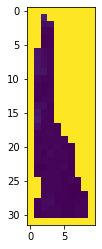

In [31]:
show(out_image[0])

As you can see, the features raster was clipped to a single polygon. There are 6 bands and 32x10 pixels. We'll repeat this process for all 6,136 polygons to build our dataset. We'll also need to clean this raster up a bit before we use it in training. We'll explore all of this next. 

But first, we'll be doing a lot of memory intensive work so we'll close the dataset for now.

In [32]:
data.close()

## Build the Training Data for `sckit-learn`

We'll repeat the above process for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

Note that the column 'MuleDeer_1' in the labels geodataframe has the label we're after.
TODO: change to column with label instead of numeric.

In [33]:
%%time  # magic command to print time required for processing
# Lets create a progress bar as this step can take some time
p_bar = IntProgress(min=0, max=len(geoms), description='Processing')
display(p_bar)

# Set up arrays
X = np.array([], dtype=np.int8).reshape(0,6)  # pixels for training
y = np.array([], dtype=np.string_)  # labels for training

# extract the raster values within the polygon
with rasterio.open(train_path) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):  # Note geoms was created above
        feature = [mapping(geom)]
        
        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True)
        # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:, ~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all bands  - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:, ~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y, [labels["MuleDeer_1"][index]] * out_image_reshaped.shape[0]) # ???
        # stack the pixels onto the pixel array
        X = np.vstack((X, out_image_reshaped))
        # increment the progress bar
        p_bar.value +=1


IntProgress(value=0, description='Processing', max=6136)

#### Save the output
We'll save the output as a numpy array to avoid the long process of rebuilding the features in the future. This will also allow us to share this analysis with others without them needing access to the input data. If this were not a tutorial, I might have ended the notebook here and started a new one for the remainder of the analysis.

I've commented out the load statements below, uncomment to load in the saved features and labels.

In [35]:
# Save features and labels
np.save('lulc-features.npy', X)
np.save('lulc-labels.npy', y)

IntProgress(value=0, max=2)

Wall time: 22.7 s


In [ ]:
# Load in data
# X = np.load('lulc-features.npy')
# y = np.load('lulc-labels.npy')

### Pairing y with X

Now that we have the image we want to classify (X) and the land cover labesl (y), let's check to make sure they match in size so we can feed them to Naive Bayes.

In [33]:
st_names = np.unique(labels["MuleDeer_1"])
print('The training data include {n} classes: {classes}\n'.format(n=st_names.size, 
                                                                classes=st_names))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 5 classes: [1 2 3 4 5]

Our X matrix is sized: (6793828, 6)
Our y array is sized: (6793828,)


That looks good. We have 5 classes (i.e., our STM names); 6 predictor features (i.e., the 6 bands in our X matrix, now flattened; and both the X and y array are the same length.

We'll treat these vegetation cover values as spectral signatures, and plot each to make sure they're actually separable since all we're going by in this classification is pixel values.

Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

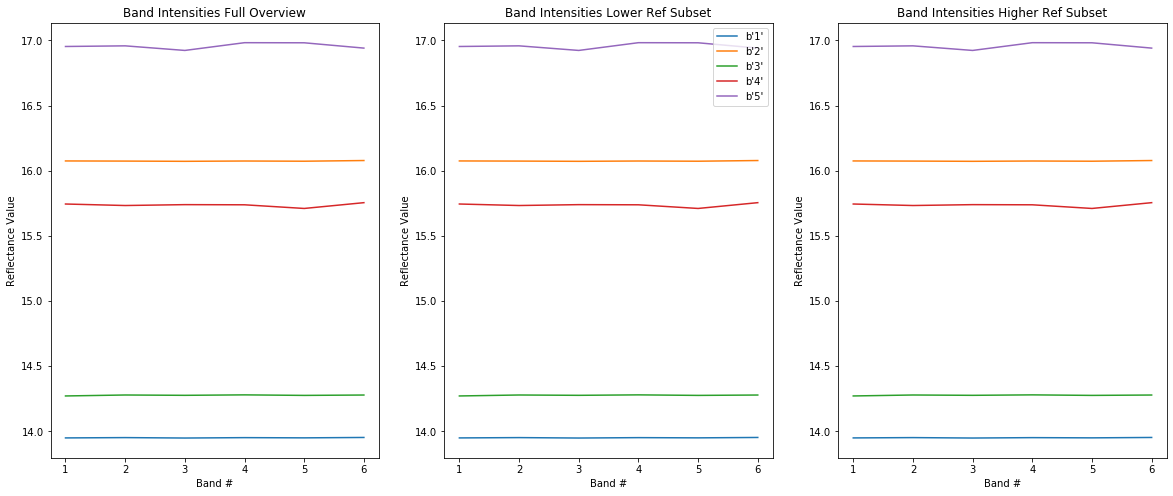

In [35]:
fig, ax = plt.subplots(1, 3, figsize=[20,8])

# bands are numbered 1 through 6 following GDAL convention
band_count = np.arange(1,7)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
#plot them as lines

# Add some axis labels
# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
ax[1].legend(loc="upper right")

# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

plt.show()

Looks like each class will be easily separable.

This will be a helper function to convert class labels into indices so we're predicting to integers instead of strings.
TODO: switch labels and numbers

In [36]:
def int_class_to_str(class_array):
    class_array[class_array == str(1)] = 'PJ'
    class_array[class_array == str(2)] = 'Perennial Shrub'
    class_array[class_array == str(3)] = 'Encroached Shrub'
    class_array[class_array == str(4)] = 'Loamy Bottom'
    class_array[class_array == str(5)] = 'Grass Meadow'
    return(class_array.astype(str))

## Training the Classifier
Now that we have our X matrix of feature inputs (the vegetation cover bands) and our y array (the labels), we can train our model.

Visit [this web page](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) to find the usage of GaussianNaiveBayes Classifier from `scikit-learn`.

In [43]:
gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

It's that simple to train a classifier in `sckit-learn`. The hard part is often validation and iterpretation.

## Predicting on the Image

With our Naive Bayes classifier fit, we can now proceed by trying to classify the entire image.

In [46]:
range_path = r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\range_clip_utm.tif'
with rasterio.open(range_path) as src:
    profile = src.profile  # the src profile will be used to save the output later
    img = src.read()

# Take our full iamge and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(6, 9412, 7341)
(9412, 7341, 6)


Now we can predict for each pixel in our image.

In [47]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 6))

# Reshape our classification map back into a 2d matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

Because we used labels as strings we will want to convert them to numpy array with integers using the helper function we made earlier.

In [48]:
# This function converts the class prediction to ints from strings because it was originally created as a string
# See template notebook for more
class_prediction = class_prediction.astype(int)

### Visualize the Results

First we'll make a colormap so we can adjust the colors of each class to more logical colors. 

In [49]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (34, 139, 34, 255)),    # Forest Green - PJ
    (1, (139,69,19, 255)),      # Brown - Perennial Shrub
    (2, (48, 156, 214, 255)),   # Blue - Encroached Shrub
    (3, (244, 164, 96, 255)),   # Tan - Loamy Bottom
    (4, (206, 224, 196, 255)),  # Lime - Grass Meadow
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v

index_colors = [colors[key] if key in colors else
               (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

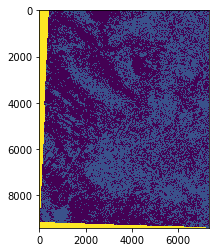

In [56]:
show(class_prediction)

How many classes were actually predicted from our data? 

In [61]:
np.unique(class_prediction)

array([1, 2, 5])

It looks like our classifier predicts all pixels into one of two different classes. This might be because our training set was imbalanced--most of our labels are also in one of those two classes. Thus, the classifier was rarely penalized for getting a rare class wrong. We'll explore how to correct for these types of issues next.

First, we'll save this prediction to disk in case we want to reference it later.

In [63]:
with rasterio.Env():
    
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')
    
    with rasterio.open(r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\example.tif', 'w', **profile) as dst:
        dst.write(class_prediction.astype(rasterio.uint8), 1)

## Improving our Model Accuracy

In the following sections (TBD), we'll improve upon our model, evaluate accuracy, and explore different classifiers
* Normalize values
* Split into training and testing data
* Balance classes in training data
* Introduce additional features (elevation, precip, soil temperature, aspect, moving window stats, imagery)
* Explore different classifiers

[Standardization](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

[Balancing Classes](https://elitedatascience.com/imbalanced-classes)

[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

[cross validation](https://scikit-learn.org/stable/modules/cross_validation.html)

[Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)

[Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)

[Accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)

[Decision Trees](): good for unbalanced datasets. How does it compare?